In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from numpy import pi, exp, sin, deg2rad, rad2deg
from numpy.linalg import svd, norm

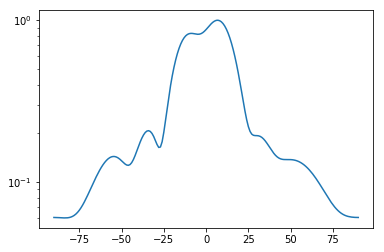

In [18]:
SNR = 20
snapshots = 200
sensorNum = 8

#----------Consider a ULA, where the array sapcing is a half wavelength of the signal.--------#
c = 3e8
f = 2.4e9                       # frequency is 2.4GHz
wavelength = c / f              # lambda
spacing = wavelength / 2        # ULA's spacing

#---------Sample: sample frequency is fs = 3f-------------------------------------------#
fs = 3 * f                      
Ts = 1 / fs                             # Sample period
Ns = Ts * np.arange(snapshots)          # Sample spacing

#----------Consider noises are generated from a zero mean Gaussian distribution.--------------#
sigma_N = 0.1
noiseCovMat = sigma_N * np.eye(sensorNum)

noiseAmp = np.random.multivariate_normal(np.zeros(sensorNum), noiseCovMat, snapshots)
noisePhase = np.mat([exp(-1j*2*pi*f*Ns + np.random.rand())])
noiseMat = np.multiply(noiseAmp, noisePhase.T)                    # Each row is A sample 

#----------Consider three sources at -10 degree, 0 degree and 10 degree.----------------------#
#----------Sources at -10 degree and 0 degree is coherent.------------------------------------#
#----------Each source is generated from a zerom mean Gaussian distribution.------------------#
theta_S = np.array([-10, 0, 10])
sourceNum = len(theta_S)
sigma_S = sigma_N * 10**(SNR/20)
signalCovMat = np.mat([[sigma_S, 0.99*sigma_S, 0], [0.99*sigma_S, sigma_S, 0], [0, 0, sigma_S]])
signalAmp = np.random.multivariate_normal(np.zeros(sourceNum), signalCovMat, snapshots)
signalPhase = np.mat([exp(-1j*2*pi*f*Ns + np.random.rand())])
signalMat = np.multiply(signalAmp, signalPhase.T)                # Each row is A sample 

spacingK = spacing * np.arange(sensorNum)
manifoldMat = np.zeros((sensorNum, sourceNum), dtype=complex)
for col in range(manifoldMat.shape[1]):
    manifoldMat[:, col] = np.mat([exp(-1j*2*pi*f*((spacingK*sin(deg2rad(theta_S[col])))/c))], dtype=complex)

sensorOut = np.dot(manifoldMat, signalMat.T) + noiseMat.T

leftVec, singularVals, rightVecH = svd(sensorOut)
dimReduceMat = np.mat(np.hstack((np.eye(sourceNum), np.zeros((sourceNum, snapshots - sourceNum))))).T
dimReducedOut = np.dot(sensorOut, rightVecH.H) * dimReduceMat
theta = np.arange(-90, 91)    # angle scan range
manifoldMat_hat = np.zeros((sensorNum, len(theta)), dtype=complex)
for col in range(manifoldMat_hat.shape[1]):
    manifoldMat_hat[:, col] = np.mat([exp(-1j*2*pi*f*((spacingK*sin(deg2rad(theta[col])))/c))], dtype=complex)

#----------SOC programming-----------------------#
p = cvx.Variable()
q = cvx.Variable()
r = cvx.Variable(len(theta))
regParam = cvx.Parameter(sign='positive')
regParam.value = 2        # experienced regularization parameter
S_sv_Re = cvx.Variable(len(theta), sourceNum)
S_sv_Im = cvx.Variable(len(theta), sourceNum)
Z_k_Re = dimReducedOut.real - (manifoldMat_hat.real*S_sv_Re - manifoldMat_hat.imag*S_sv_Im)
Z_k_Im = dimReducedOut.imag - (manifoldMat_hat.real*S_sv_Im + manifoldMat_hat.imag*S_sv_Re)
S_sv_hat_Re = cvx.norm(S_sv_Re, axis=1)
S_sv_hat_Im = cvx.norm(S_sv_Im, axis=1)
obj = cvx.Minimize(p + regParam*q)
constraints = [cvx.norm(Z_k_Re, 'fro')**2 + cvx.norm(Z_k_Im, 'fro')**2 <= p,
               cvx.norm(S_sv_hat_Re**2 + S_sv_hat_Im**2, 1) <= q
              ]
    
prob = cvx.Problem(obj, constraints)
prob.solve()
P_hat = np.array(S_sv_hat_Re.value + 1j*S_sv_hat_Im.value)
plt.semilogy(theta, abs(P_hat)/np.max(abs(P_hat)))
plt.show()